In [218]:
%load_ext autoreload
%autoreload 2
import timeit
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120
import sys; sys.path.append('../')
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from tqdm import tqdm
from src.utils.graphs import get_keypoints, relative_neighborhood, random_graph
from src.utils.visualize import plot_voronoi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from math import sqrt
import numpy as np
import cv2 as cv2
from scipy.stats import entropy
from shapely.geometry import Polygon, Point

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
N_FEATURES_LIMIT = None 
test_img_path = r"../test_images/test_img_3.jpg"
train_set = r"../data/Ki67/SHIDC-B-Ki-67/Train"

In [177]:
img_arr = cv2.imread(test_img_path)

In [178]:
img_arr.shape

(1228, 1228, 3)

In [179]:
len(keys) != len(set(keys))

True

empty 429
[]
[]


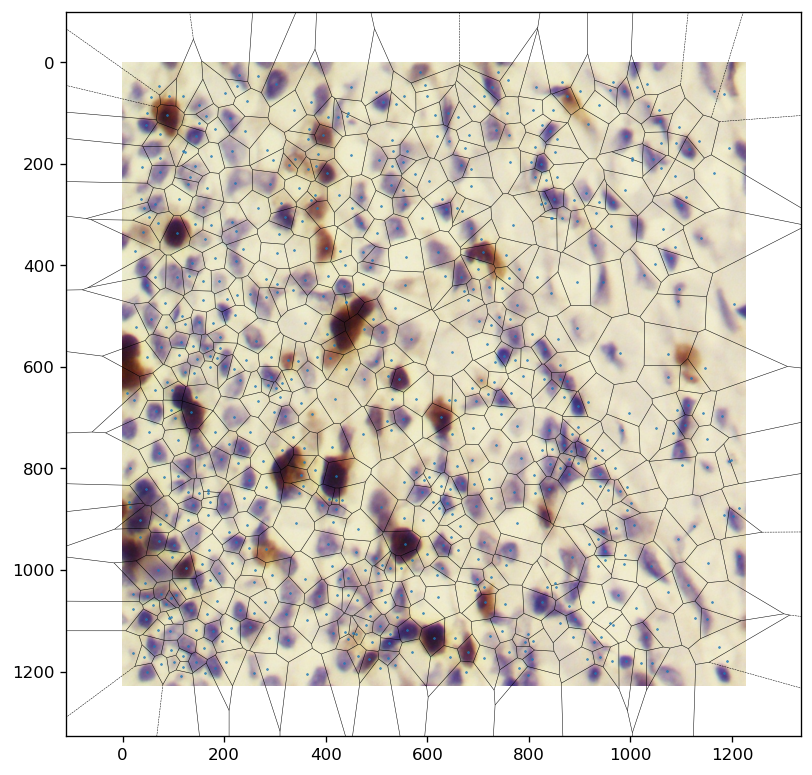

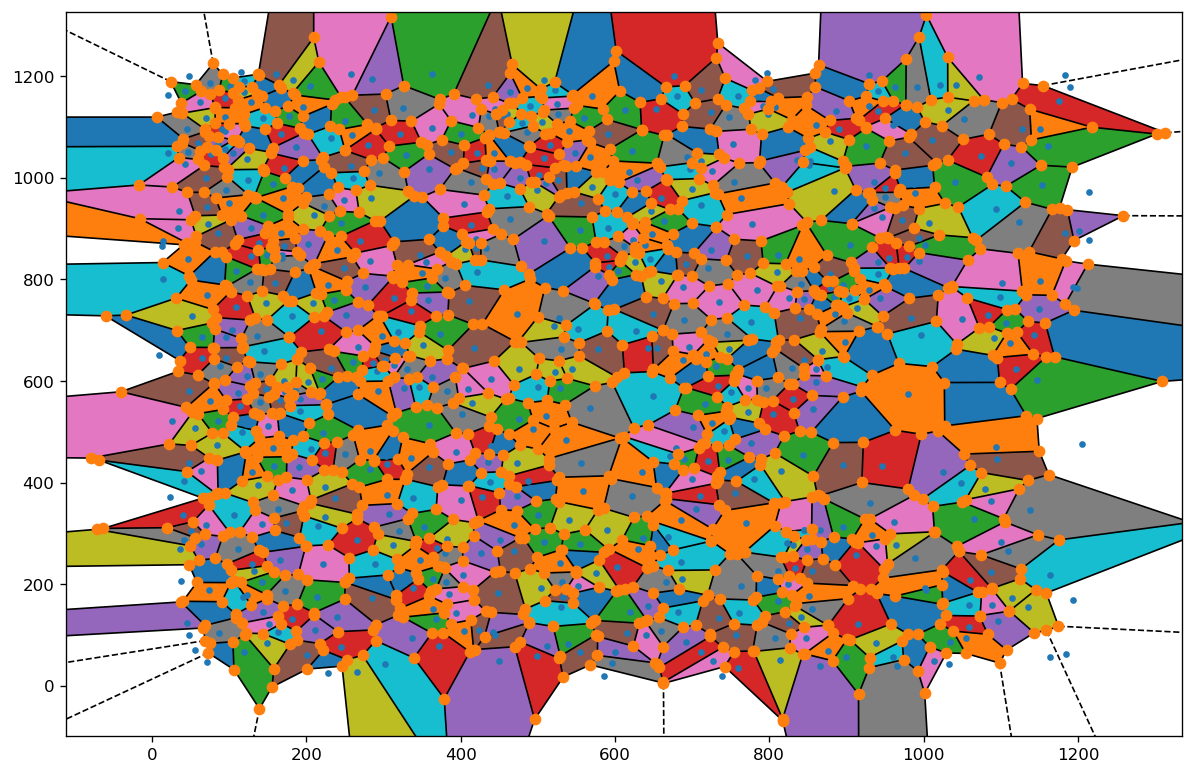

In [180]:
img_arr = plt.imread(test_img_path)
keys = list(get_keypoints(img_arr,N_FEATURES_LIMIT,True))
pixels = [key[1] for key in keys]
keys = [key[0] for key in keys]
assert len(keys)==len(pixels)
vor = Voronoi(keys)
plot_voronoi(vor,img_arr,show_points=True,show_verticles=False,line_width=0.3)


# plot
voronoi_plot_2d(vor)

# colorize
polygons = []
for idx ,region in enumerate(vor.regions):
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        x = Polygon(polygon)
        if x.is_empty:
            print('empty',idx)
            print(polygon)
            print(region)
            continue
        plt.fill(*zip(*polygon))
        polygons.append(Polygon(polygon))
plt.show()

In [181]:
keys

[(9.411873817443848, 651.4326171875),
 (13.23269271850586, 866.6105346679688),
 (14.287022590637207, 876.140380859375),
 (14.888208389282227, 800.099365234375),
 (20.74563217163086, 1163.2991943359375),
 (20.769451141357422, 1076.254150390625),
 (20.94198226928711, 1048.147705078125),
 (22.69807243347168, 665.9479370117188),
 (23.53858184814453, 372.3703918457031),
 (25.923166275024414, 521.0264892578125),
 (33.797672271728516, 901.0381469726562),
 (34.901119232177734, 935.072265625),
 (36.47665023803711, 269.29931640625),
 (37.70613479614258, 207.0508270263672),
 (40.66352462768555, 335.35931396484375),
 (41.229583740234375, 404.1212463378906),
 (41.42756652832031, 287.8712463378906),
 (42.8334846496582, 1170.5238037109375),
 (43.49024200439453, 1026.5450439453125),
 (45.82614517211914, 1096.3792724609375),
 (46.00666809082031, 124.10901641845703),
 (46.1385383605957, 841.06640625),
 (47.102989196777344, 1050.590087890625),
 (47.71012878417969, 580.8738403320312),
 (48.054290771484375

In [182]:
def get_pixels(polygon,img_array):
    pixels = []
    for x,x_vec in tqdm(enumerate(img_arr)):
        for y, y_vec in enumerate(x_vec):
            p = Point(x,y)
            if polygon.contains(p):
                pixels.append(y_vec)
    pixels = np.array(pixels)
    gray = np.dot(pixels[...,:3], [0.2989, 0.5870, 0.1140])
    return gray

def get_pixels_fast(polygon,img_array):
    #(minx, miny, maxx, maxy)
    pixels = []
    shape = img_array.shape
    (minx, miny, maxx, maxy)=[int(item) for item in list(polygon.bounds)]
    x_range = range(minx,maxx-1)
    y_range = range(miny,maxy-1)
    for x in x_range:
        if x >= shape[0] or x <= -1:
            continue
        for y in y_range:
            if y >= shape[1] or y <=-1:
                continue
            p = Point(x,y)
            if polygon.contains(p):
                pixels.append(img_arr[x][y])
    pixels = np.array(pixels)
    gray = np.dot(pixels[...,:3], [0.2989, 0.5870, 0.1140])
    return gray

In [183]:
def count_entropy(pixels):
    value,counts = np.unique(pixels, return_counts=True)
    entropy_value = entropy(counts)
    return entropy_value

In [190]:
def find_key(polygon,keys,pixels):
    inside = []
    pixel_color = []
    for idx, key in enumerate(keys):
        p = Point(key[0],key[1])
        if polygon.contains(p):
            inside.append(key)
            #print(idx)
            #print(len(keys),len(pixels))
            pixel_color.append(pixels[idx])
    #print(inside)
    return inside, pixel_color

In [191]:
entropy_list = []
keys_list = []
pixel_list = []

In [192]:
for polygon in tqdm(polygons):
    entropy_list.append(count_entropy(get_pixels_fast(polygon,img_arr)))
    key, pixel = find_key(polygon,vor._points,pixels)
    keys_list.append(key)
    pixel_list.append(pixel)

100%|████████████████████████████████████████████████████████████████████████████████| 671/671 [00:59<00:00, 11.30it/s]


In [241]:
COLORS  = ( (185, 122, 87),  #brown
            (255, 255, 255), #white
            (153, 217, 234)) #light blue

def closest_color(pixel):
    pixel_rgb = pixel[0]
    r, g, b = pixel_rgb
    color_diffs = []
    for color in COLORS:
        cr, cg, cb = color
        color_diff = sqrt(abs(r - cr)**2 + abs(g - cg)**2 + abs(b - cb)**2)
        color_diffs.append((color_diff, color))
    min_color = min(color_diffs)[1]
    color = {
        0 : 'brown',
        1 :'white',
        2 :'blue'
    }
   # print(min_color)
    pixel_color = COLORS.index(min_color)
    return color[pixel_color]

In [242]:
pixel_colors = [closest_color(pixel) for pixel in pixel_list]

In [243]:
pixel_colors

['blue',
 'white',
 'blue',
 'brown',
 'brown',
 'blue',
 'white',
 'blue',
 'blue',
 'brown',
 'white',
 'blue',
 'brown',
 'brown',
 'white',
 'white',
 'white',
 'blue',
 'white',
 'white',
 'brown',
 'brown',
 'white',
 'blue',
 'blue',
 'white',
 'white',
 'white',
 'white',
 'blue',
 'white',
 'white',
 'brown',
 'blue',
 'blue',
 'blue',
 'blue',
 'white',
 'white',
 'blue',
 'white',
 'brown',
 'blue',
 'brown',
 'brown',
 'blue',
 'white',
 'blue',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'blue',
 'blue',
 'white',
 'white',
 'blue',
 'white',
 'blue',
 'white',
 'blue',
 'white',
 'brown',
 'blue',
 'white',
 'white',
 'blue',
 'white',
 'white',
 'white',
 'brown',
 'blue',
 'brown',
 'white',
 'white',
 'brown',
 'white',
 'white',
 'white',
 'white',
 'blue',
 'white',
 'white',
 'blue',
 'white',
 'white',
 'blue',
 'blue',
 'blue',
 'white',
 'white',
 'brown',
 'white',
 'brown',
 'brown',
 'brown',
 'brown',
 'blue',
 'brown',
 'blue',
 'b

In [244]:
import pandas as pd
dic = {
    'key':keys_list,
    'color':pixel_colors,
    'entropy':entropy_list,
}
df = pd.DataFrame(dic)
df.head(10)

,key,color,entropy
0,"[[1180.2052001953125, 696.9932250976562]]",blue,8.024161
1,"[[14.287022590637207, 876.140380859375]]",white,5.632229
2,"[[42.8334846496582, 1170.5238037109375]]",blue,6.306780
3,"[[1142.7135009765625, 690.1985473632812]]",brown,7.453311
4,"[[1149.6802978515625, 741.5813598632812]]",brown,7.530594
5,"[[1095.4451904296875, 446.59906005859375]]",blue,8.021984
6,"[[1086.907958984375, 364.0002136230469]]",white,6.251032
7,"[[1138.5296630859375, 346.2148132324219]]",blue,7.128004
8,"[[1079.9140625, 386.598388671875]]",blue,7.079147
9,"[[1049.146484375, 398.38397216796875]]",brown,7.290617


In [248]:
import plotly.express as px

fig = px.histogram(df, x="entropy",color='color')
fig.show()
